In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "int98"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 219
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 291
Categorical Columns: 8


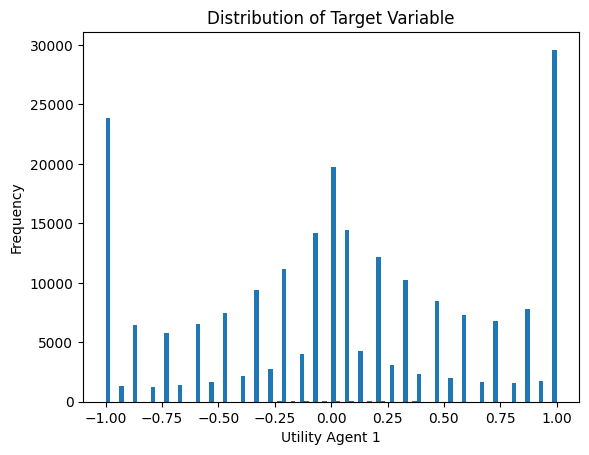

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55407


[100]	val-rmse:0.46545


[200]	val-rmse:0.44727


[300]	val-rmse:0.43845


[400]	val-rmse:0.43299


[500]	val-rmse:0.43031


[600]	val-rmse:0.42829


[700]	val-rmse:0.42699


[800]	val-rmse:0.42604


[900]	val-rmse:0.42553


[1000]	val-rmse:0.42507


[1100]	val-rmse:0.42479


[1200]	val-rmse:0.42431


[1300]	val-rmse:0.42422


[1400]	val-rmse:0.42423


[1500]	val-rmse:0.42415


[1600]	val-rmse:0.42414


[1700]	val-rmse:0.42414


[1800]	val-rmse:0.42414


[1900]	val-rmse:0.42413


[2000]	val-rmse:0.42419


[2100]	val-rmse:0.42411


[2200]	val-rmse:0.42403


[2300]	val-rmse:0.42411


[2400]	val-rmse:0.42408


[2499]	val-rmse:0.42413


Fold 1 - RMSE: 0.42383139963906574
Fold 2


[0]	val-rmse:0.58914


[100]	val-rmse:0.47707


[200]	val-rmse:0.46155


[300]	val-rmse:0.45498


[400]	val-rmse:0.45088


[500]	val-rmse:0.44863


[600]	val-rmse:0.44719


[700]	val-rmse:0.44639


[800]	val-rmse:0.44568


[900]	val-rmse:0.44517


[1000]	val-rmse:0.44470


[1100]	val-rmse:0.44445


[1200]	val-rmse:0.44397


[1300]	val-rmse:0.44365


[1400]	val-rmse:0.44330


[1500]	val-rmse:0.44319


[1600]	val-rmse:0.44299


[1700]	val-rmse:0.44293


[1800]	val-rmse:0.44284


[1900]	val-rmse:0.44284


[2000]	val-rmse:0.44274


[2100]	val-rmse:0.44274


[2200]	val-rmse:0.44266


[2300]	val-rmse:0.44267


[2400]	val-rmse:0.44260


[2499]	val-rmse:0.44258


Fold 2 - RMSE: 0.44212072904654115
Fold 3


[0]	val-rmse:0.60680


[100]	val-rmse:0.48150


[200]	val-rmse:0.46058


[300]	val-rmse:0.45304


[400]	val-rmse:0.44812


[500]	val-rmse:0.44561


[600]	val-rmse:0.44413


[700]	val-rmse:0.44314


[800]	val-rmse:0.44259


[900]	val-rmse:0.44216


[1000]	val-rmse:0.44173


[1100]	val-rmse:0.44129


[1200]	val-rmse:0.44101


[1300]	val-rmse:0.44090


[1400]	val-rmse:0.44082


[1500]	val-rmse:0.44060


[1600]	val-rmse:0.44058


[1700]	val-rmse:0.44058


[1800]	val-rmse:0.44049


[1900]	val-rmse:0.44046


[2000]	val-rmse:0.44049


[2100]	val-rmse:0.44041


[2200]	val-rmse:0.44028


[2300]	val-rmse:0.44024


[2400]	val-rmse:0.44015


[2499]	val-rmse:0.44012


Fold 3 - RMSE: 0.43965783390776636
Fold 4


[0]	val-rmse:0.59646


[100]	val-rmse:0.48376


[200]	val-rmse:0.46409


[300]	val-rmse:0.45626


[400]	val-rmse:0.45132


[500]	val-rmse:0.44801


[600]	val-rmse:0.44599


[700]	val-rmse:0.44480


[800]	val-rmse:0.44387


[900]	val-rmse:0.44305


[1000]	val-rmse:0.44249


[1100]	val-rmse:0.44197


[1200]	val-rmse:0.44149


[1300]	val-rmse:0.44123


[1400]	val-rmse:0.44085


[1500]	val-rmse:0.44049


[1600]	val-rmse:0.44039


[1700]	val-rmse:0.44026


[1800]	val-rmse:0.44024


[1900]	val-rmse:0.44017


[2000]	val-rmse:0.44007


[2100]	val-rmse:0.44007


[2200]	val-rmse:0.44009


[2300]	val-rmse:0.44003


[2400]	val-rmse:0.43998


[2499]	val-rmse:0.43997


Fold 4 - RMSE: 0.43955966780434025
Fold 5


[0]	val-rmse:0.54753


[100]	val-rmse:0.45549


[200]	val-rmse:0.43533


[300]	val-rmse:0.42423


[400]	val-rmse:0.41797


[500]	val-rmse:0.41445


[600]	val-rmse:0.41215


[700]	val-rmse:0.41111


[800]	val-rmse:0.41013


[900]	val-rmse:0.40917


[1000]	val-rmse:0.40857


[1100]	val-rmse:0.40818


[1200]	val-rmse:0.40786


[1300]	val-rmse:0.40766


[1400]	val-rmse:0.40761


[1500]	val-rmse:0.40741


[1600]	val-rmse:0.40735


[1700]	val-rmse:0.40724


[1800]	val-rmse:0.40721


[1900]	val-rmse:0.40709


[2000]	val-rmse:0.40707


[2100]	val-rmse:0.40706


[2200]	val-rmse:0.40712


[2300]	val-rmse:0.40727


[2400]	val-rmse:0.40731


[2499]	val-rmse:0.40740


Fold 5 - RMSE: 0.40709004352430017
List of oof scores: [0.42383139963906574, 0.44212072904654115, 0.43965783390776636, 0.43955966780434025, 0.40709004352430017]
Average oof score: 0.43045193478440275


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53538


[100]	val-rmse:0.44743


[200]	val-rmse:0.43082


[300]	val-rmse:0.42255


[400]	val-rmse:0.41785


[500]	val-rmse:0.41542


[600]	val-rmse:0.41419


[700]	val-rmse:0.41302


[800]	val-rmse:0.41228


[900]	val-rmse:0.41150


[1000]	val-rmse:0.41123


[1100]	val-rmse:0.41070


[1200]	val-rmse:0.41041


[1300]	val-rmse:0.41010


[1400]	val-rmse:0.40991


[1500]	val-rmse:0.40972


[1600]	val-rmse:0.40958


[1700]	val-rmse:0.40948


[1800]	val-rmse:0.40942


[1900]	val-rmse:0.40931


[2000]	val-rmse:0.40919


[2100]	val-rmse:0.40910


[2200]	val-rmse:0.40908


[2300]	val-rmse:0.40902


[2400]	val-rmse:0.40900


[2499]	val-rmse:0.40891


Fold 1 - RMSE: 0.4087095356093052
Fold 2


[0]	val-rmse:0.54720


[100]	val-rmse:0.43728


[200]	val-rmse:0.41969


[300]	val-rmse:0.41391


[400]	val-rmse:0.41065


[500]	val-rmse:0.40912


[600]	val-rmse:0.40823


[700]	val-rmse:0.40754


[800]	val-rmse:0.40700


[900]	val-rmse:0.40687


[1000]	val-rmse:0.40669


[1100]	val-rmse:0.40641


[1200]	val-rmse:0.40630


[1300]	val-rmse:0.40619


[1400]	val-rmse:0.40632


[1500]	val-rmse:0.40613


[1600]	val-rmse:0.40611


[1700]	val-rmse:0.40610


[1800]	val-rmse:0.40617


[1900]	val-rmse:0.40629


[2000]	val-rmse:0.40637


[2100]	val-rmse:0.40659


[2200]	val-rmse:0.40670


[2300]	val-rmse:0.40673


[2400]	val-rmse:0.40678


[2499]	val-rmse:0.40685


Fold 2 - RMSE: 0.4064029787647767
Fold 3


[0]	val-rmse:0.61428


[100]	val-rmse:0.49151


[200]	val-rmse:0.46730


[300]	val-rmse:0.45720


[400]	val-rmse:0.45153


[500]	val-rmse:0.44805


[600]	val-rmse:0.44561


[700]	val-rmse:0.44430


[800]	val-rmse:0.44303


[900]	val-rmse:0.44232


[1000]	val-rmse:0.44165


[1100]	val-rmse:0.44094


[1200]	val-rmse:0.44045


[1300]	val-rmse:0.43984


[1400]	val-rmse:0.43953


[1500]	val-rmse:0.43920


[1600]	val-rmse:0.43902


[1700]	val-rmse:0.43888


[1800]	val-rmse:0.43873


[1900]	val-rmse:0.43852


[2000]	val-rmse:0.43843


[2100]	val-rmse:0.43837


[2200]	val-rmse:0.43830


[2300]	val-rmse:0.43821


[2400]	val-rmse:0.43805


[2499]	val-rmse:0.43814


Fold 3 - RMSE: 0.43781943636860754
Fold 4


[0]	val-rmse:0.60680


[100]	val-rmse:0.48697


[200]	val-rmse:0.46350


[300]	val-rmse:0.45479


[400]	val-rmse:0.44954


[500]	val-rmse:0.44734


[600]	val-rmse:0.44545


[700]	val-rmse:0.44418


[800]	val-rmse:0.44323


[900]	val-rmse:0.44252


[1000]	val-rmse:0.44199


[1100]	val-rmse:0.44150


[1200]	val-rmse:0.44102


[1300]	val-rmse:0.44077


[1400]	val-rmse:0.44047


[1500]	val-rmse:0.44019


[1600]	val-rmse:0.44003


[1700]	val-rmse:0.43991


[1800]	val-rmse:0.43982


[1900]	val-rmse:0.43986


[2000]	val-rmse:0.43980


[2100]	val-rmse:0.43981


[2200]	val-rmse:0.43968


[2300]	val-rmse:0.43985


[2400]	val-rmse:0.43971


[2499]	val-rmse:0.43972


Fold 4 - RMSE: 0.43942046112860855
Fold 5


[0]	val-rmse:0.59190


[100]	val-rmse:0.48227


[200]	val-rmse:0.45872


[300]	val-rmse:0.44903


[400]	val-rmse:0.44384


[500]	val-rmse:0.44098


[600]	val-rmse:0.43912


[700]	val-rmse:0.43785


[800]	val-rmse:0.43685


[900]	val-rmse:0.43619


[1000]	val-rmse:0.43566


[1100]	val-rmse:0.43524


[1200]	val-rmse:0.43465


[1300]	val-rmse:0.43447


[1400]	val-rmse:0.43418


[1500]	val-rmse:0.43393


[1600]	val-rmse:0.43379


[1700]	val-rmse:0.43376


[1800]	val-rmse:0.43362


[1900]	val-rmse:0.43348


[2000]	val-rmse:0.43339


[2100]	val-rmse:0.43342


[2200]	val-rmse:0.43333


[2300]	val-rmse:0.43346


[2400]	val-rmse:0.43346


[2499]	val-rmse:0.43346


Fold 5 - RMSE: 0.43295551331100285
List of oof scores: [0.4087095356093052, 0.4064029787647767, 0.43781943636860754, 0.43942046112860855, 0.43295551331100285]
Average oof score: 0.4250615850364602


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57619


[100]	val-rmse:0.47778


[200]	val-rmse:0.45844


[300]	val-rmse:0.45000


[400]	val-rmse:0.44584


[500]	val-rmse:0.44346


[600]	val-rmse:0.44205


[700]	val-rmse:0.44107


[800]	val-rmse:0.44034


[900]	val-rmse:0.43973


[1000]	val-rmse:0.43947


[1100]	val-rmse:0.43896


[1200]	val-rmse:0.43873


[1300]	val-rmse:0.43851


[1400]	val-rmse:0.43830


[1500]	val-rmse:0.43825


[1600]	val-rmse:0.43820


[1700]	val-rmse:0.43807


[1800]	val-rmse:0.43803


[1900]	val-rmse:0.43788


[2000]	val-rmse:0.43795


[2100]	val-rmse:0.43787


[2200]	val-rmse:0.43778


[2300]	val-rmse:0.43775


[2400]	val-rmse:0.43767


[2499]	val-rmse:0.43772


Fold 1 - RMSE: 0.4372461230168906
Fold 2


[0]	val-rmse:0.57480


[100]	val-rmse:0.46348


[200]	val-rmse:0.44215


[300]	val-rmse:0.43193


[400]	val-rmse:0.42595


[500]	val-rmse:0.42258


[600]	val-rmse:0.42031


[700]	val-rmse:0.41865


[800]	val-rmse:0.41774


[900]	val-rmse:0.41672


[1000]	val-rmse:0.41590


[1100]	val-rmse:0.41537


[1200]	val-rmse:0.41512


[1300]	val-rmse:0.41478


[1400]	val-rmse:0.41459


[1500]	val-rmse:0.41420


[1600]	val-rmse:0.41424


[1700]	val-rmse:0.41411


[1800]	val-rmse:0.41415


[1900]	val-rmse:0.41402


[2000]	val-rmse:0.41397


[2100]	val-rmse:0.41385


[2200]	val-rmse:0.41375


[2300]	val-rmse:0.41371


[2400]	val-rmse:0.41371


[2499]	val-rmse:0.41367


Fold 2 - RMSE: 0.41342488723689896
Fold 3


[0]	val-rmse:0.57845


[100]	val-rmse:0.47351


[200]	val-rmse:0.45614


[300]	val-rmse:0.44860


[400]	val-rmse:0.44447


[500]	val-rmse:0.44244


[600]	val-rmse:0.44123


[700]	val-rmse:0.44022


[800]	val-rmse:0.43933


[900]	val-rmse:0.43892


[1000]	val-rmse:0.43843


[1100]	val-rmse:0.43828


[1200]	val-rmse:0.43807


[1300]	val-rmse:0.43787


[1400]	val-rmse:0.43759


[1500]	val-rmse:0.43735


[1600]	val-rmse:0.43716


[1700]	val-rmse:0.43695


[1800]	val-rmse:0.43660


[1900]	val-rmse:0.43655


[2000]	val-rmse:0.43645


[2100]	val-rmse:0.43629


[2200]	val-rmse:0.43636


[2300]	val-rmse:0.43645


[2400]	val-rmse:0.43640


[2499]	val-rmse:0.43636


Fold 3 - RMSE: 0.43604671765011854
Fold 4


[0]	val-rmse:0.57676


[100]	val-rmse:0.45831


[200]	val-rmse:0.44083


[300]	val-rmse:0.43305


[400]	val-rmse:0.42844


[500]	val-rmse:0.42560


[600]	val-rmse:0.42366


[700]	val-rmse:0.42252


[800]	val-rmse:0.42155


[900]	val-rmse:0.42083


[1000]	val-rmse:0.42005


[1100]	val-rmse:0.41962


[1200]	val-rmse:0.41936


[1300]	val-rmse:0.41918


[1400]	val-rmse:0.41890


[1500]	val-rmse:0.41880


[1600]	val-rmse:0.41882


[1700]	val-rmse:0.41869


[1800]	val-rmse:0.41868


[1900]	val-rmse:0.41862


[2000]	val-rmse:0.41857


[2100]	val-rmse:0.41850


[2200]	val-rmse:0.41839


[2300]	val-rmse:0.41846


[2400]	val-rmse:0.41851


[2499]	val-rmse:0.41844


Fold 4 - RMSE: 0.4180274139373839
Fold 5


[0]	val-rmse:0.58679


[100]	val-rmse:0.47650


[200]	val-rmse:0.45709


[300]	val-rmse:0.44734


[400]	val-rmse:0.44105


[500]	val-rmse:0.43733


[600]	val-rmse:0.43517


[700]	val-rmse:0.43366


[800]	val-rmse:0.43267


[900]	val-rmse:0.43184


[1000]	val-rmse:0.43130


[1100]	val-rmse:0.43078


[1200]	val-rmse:0.43014


[1300]	val-rmse:0.42968


[1400]	val-rmse:0.42943


[1500]	val-rmse:0.42929


[1600]	val-rmse:0.42922


[1700]	val-rmse:0.42914


[1800]	val-rmse:0.42911


[1900]	val-rmse:0.42900


[2000]	val-rmse:0.42888


[2100]	val-rmse:0.42892


[2200]	val-rmse:0.42895


[2300]	val-rmse:0.42887


[2400]	val-rmse:0.42878


[2499]	val-rmse:0.42882


Fold 5 - RMSE: 0.4284993238086003
List of oof scores: [0.4372461230168906, 0.41342488723689896, 0.43604671765011854, 0.4180274139373839, 0.4284993238086003]
Average oof score: 0.42664889312997845


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4238
Score: 0.4421
Score: 0.4397
Score: 0.4396
Score: 0.4071
Average CV1 Score: 0.4305

CV2 OOF Scores:
Score: 0.4087
Score: 0.4064
Score: 0.4378
Score: 0.4394
Score: 0.4330
Average CV2 Score: 0.4251

CV3 OOF Scores:
Score: 0.4372
Score: 0.4134
Score: 0.4360
Score: 0.4180
Score: 0.4285
Average CV3 Score: 0.4266


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

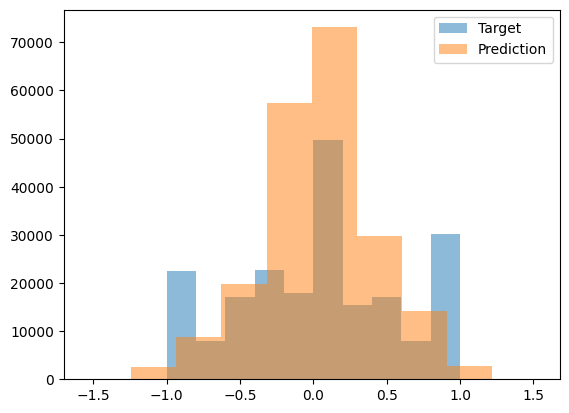

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***